Progress Report 1
----

**Team Members**

Yaqian Cheng, Department of Statistical Science

Mengrun Li, Department of Statistical Science

**Github repository**

<https://github.com/cici7941/Sta_663_Statistical_Computation_Final_Project>

**Choice of paper** 

*Scalable K-Means++*

**Abstract**

*K-means* is one of the most popular clustering methods. A good initialization of *k-means* is essential for obtaining the global optimal solution and efficiency. However, there are two main obstacles with traditional *k-means* method. One is theoretical inefficiency and the other one is that its final solution is locally optimal. A better algorithm, *k-means++* addresses the second problem with an improved initialization procedure of the cluster centers. But this *k-means++* initialization is not parallelizable, because the selection for the *i*th center depends on the previous *i-1* centers [1]. Therefore, *k-means||*, a parallelizable version of *k-means++*, has been raised, which can both improve the final solution and run faster. In this report, we implemented the algorithm in the paper "Scalable K-Means++" in Python, compared the clustering cost and runtime between *k-means*, *k-means++* and *k-means||*, performed tests for main functions, profiled the performance of the algorithm and identified bottlenecks, and performed optimization using Cython. We then apply *k-means||* to a massive dataset to evaluate its performance.

**Outline**

1. Background
2. Algorithm Description  
    2.1 Notation  
    2.2 K-Means  
    2.3 Better initialization: K-means++ and K-means||   
       2.3.1 K-means++ initialization  
       2.3.2 K-means|| initialization  
3. Testing
4. Profiling and Optimization
5. Application and Comparison

1. Background
-----
Unsupervised learning is to ask the computer itself to identify the underlying features of data without given specific labels of each group. It is very useful when first given a large amount of data. *K-means* is one of the most popular clustering methods. A good initialization of *K-means* is essential for obtaining the global optimal solution and efficiency. However, there are two main obstacles with traditional *K-means* method. One is theoretical inefficiency and the other one is that its final solution is locally optimal. A better algorithm, *K-means++* addresses the second problem with an improved initialization procedure of the cluster centers. But this *K-means++* initialization is not parallelizable, because the selection for the *i*th center depends on the previous *i-1* centers [1]. Therefore, *K-means||*, a parallelizable version of *K-means++*, has been raised, which can both improve the final solution and run faster. In this report, we implemented the algorithm in the paper "Scalable K-Means++" writen by Bahman Bahmani, Benjamin Moseley, Andrea Vattani, Ravi Kumar and Sergei Vassilvitskii in Python, compared the clustering cost and runtime between *K-means*, *K-means++* and *K-means||*, performed tests for main functions, profiled the performance of the algorithm and identified bottlenecks, and performed optimization using Cython. We then apply three kmeans methods to a simulated dataset and a real dataset to evaluate its performance.

2. Algorithm Description
-----
### 2.1 Notation  
Let $X = {x_1,...,x_n}$ be a set of points in the d-dimensional Euclidean space and let k be the positive integer which represents the number of clusters. Let $||x_i-x_j||$ denote the Euclidean distance between $x_i$ and $x_j$.[1] For a point x and a set $Y$, the distance is defined as $$d(x,Y) = min_{y\in Y}||x-y||.$$ 
Let $C = {c_1,..., c_k}$ be a set of points and define the cost of Y with respect to C as 
$$\phi_Y(C) = \sum_{y\in Y}d^2(y,C) = \sum_{y\in Y}min_{i = 1,...,k}||y-c_i||^2.$$
We denote $C$ as the set of centers of clusters, thus a clustering of X is defines as the ith cluster is the set of all points in X that are closer to $c_i\in C$ than any other $c_j\in C, j \neq i$.  
### 2.2 K-means  
The K-means clustering algorithm approximately minimizes within-cluster variation$$\sum_{k=1}^K\sum_{C(i)=k}||x_i-c_k||^2.$$ 
It start with an initial guess for $c_1,...,c_k$(e.g., pick K points at random over the range of $x_1,...,x_n$), then repeat:
1. Minimize over within-cluster variation: for each i = 1, . . . n, find the cluster center $c_k$ closest to $x_i$, and let C(i) = k
2. Minimize over $c_1,...,c_k$: for each k = 1,...K, let $c_k$ = $\bar X_k$ ( $\bar X_k$ is the average of the points in kth cluster).  Stop when within-cluster variation doesn’t change.  

### 2.3 Better initialization: K-means++ and K-means||  
### 2.3.1 K-means++ initialization  
The main idea of K-means++ is to choose the centers one by one instead of choosing K centroids directly. The centroid chose before will influence the choice of next center. The algorithm is as follows:  
**Algorithm 1** *k-means++(k)* initialization 
1. $C$ $\leftarrow$ sample a point uniformly at random from $X$  
2. **while** |$C$| < $k$ **do**  
Sample $x \in X$ with probability $\frac{d^2(x,C)}{\psi_X(C)}$  
$C$ $\leftarrow$ $C$ $\cup$ $\{x\}$  
**end while** 
 
### 2.3.2 K-means|| initialization
Since the inherent drawback of K-means++ is the initialization is not scalable since the choice of next center depends on the current set of centers, a parallelizable initialization, K-means||, has been raised. *k-means||* uses an oversampling factor $l = \Omega(k)$, which is unlike *k-means++*. Intuitively, *l* should be thought of as $\Theta$(k). This initialization algorithm picks an initial center uniformly from the dataset and computes $\psi$, here is initial cost of the clustering of this selection. Then do log$\psi$ iterations and in each iteration, it samples each x with probability $l*d^2(x,C)/\psi_X(C)$ given current set $C$ of centers. If the point is sampled, it will be added to $C$ and the quantity $\phi_X(C)$ updated and interation continued. The expected number of points chosen in each iteration is l. Since there is oversampling factor, thus the number of points in $C$ will be more than k. To reduce the number of centers, weight each point in $C$ by the number of points in $X$ whose distance to this point is shorter than it of any other point in $C$. And then recluster the weighted points to obtain k centers.  
**Algorithm 2** *k-means||(k,l)* initialization  
1. $C$ $\leftarrow$ sample a point uniformly at random from $X$  
2. $\psi$ $\leftarrow$ $\phi_X(C)$  
3. **for** O(log$\psi$) times **do**  
      $\,\,$ $C'$ $\leftarrow$ sample each point $x \in X$ independently with probability $p_x = \frac{l*d^2(x,C)}{\phi_X(C)}$  
      $\,\,$ $C$ $\leftarrow$ $C$ $\cup$ $C'$  
   **end for**  
4. For x $\in$ $C$, set $w_x$ to be the number of points in X closer to x than any other point in C  
5. Recluster the weighted points in C into k clusters

In [44]:
import scipy.linalg as la
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import operator as op
from functools import reduce
from numpy.testing import assert_almost_equal
import random

In [45]:
random.seed(1234)

In [9]:
## helper functions

#Function to calculate Euclidean distance
#Input: x, a number or array-like vectors
#       y, a number or array-like vectors
#Output: l2 norm of x and y
def euc_dist(x, y):
    return la.norm(x-y)

#Function to calculate the distance between a point and a set
#Input: x, a number or array-like vector
#       y, a set of numbers or array-like vectors
#Output: the minimum distance between the given point x and any points in set Y
def d(x, Y):
    dist = [euc_dist(x, yi) for yi in Y]
    return min(dist)

#Function to calculate the cost
#Input: Y, a set of numbers or array-like vectors
#       C, a set of numbers or array-like vectors
#Output: sum of the distance from each point in Y to C
def cost(Y, C):
    return sum(d(yi, C)**2 for yi in Y)

In [10]:
#K-Means++ initialization
#Input: X, a set of numbers or array-like vectors
#       k, the number of clusters
#Output: initial centers
def kmeans_plus(X, k):
    #choose the first possible center randomly
    idx = np.random.choice(X.shape[0], 1)
    C = X[idx, :]
    #each time sample only one point 
    while(C.shape[0] < k):
        cost_X = cost(X, C)
        prob = [d(xi,C)**2/cost_X for xi in X]
        Ct = X[np.random.choice(X.shape[0], size=1, p=prob),:]
        #if the sampled point is not in current center set C, add it to C, update C
        if(Ct.tolist() not in C.tolist()):
            C = np.r_[C, Ct]
    return C

In [11]:
#helper function for scalable k-means++ sampling
#Input: X, a set of numbers or array-like vectors, data
#       C, a set of numbers or array-like vectors, current center set
#       cost_X, current cost of current clustering state
#       l, oversampling factor
#Output: updated possible initial center set
def scalable_kmeans_sample(X, C, cost_X, l):
    Ct = np.empty([0,C.shape[1]])
    prob = list(map(lambda x:l*d(x,C)**2/cost_X, X))
    #sample each point in X independently, add it to current center set if it is not in center set
    for j in range(len(X)):
            if(prob[j] > 1):
                point = 1
            else:
                #use bernoulli to sample each point
                point = np.random.binomial(1,prob[j],size = 1)
            if point == 1 and (X[j,:].tolist() not in C.tolist()):
                Ct = np.r_[Ct, [X[j,:]]]
    return np.r_[C, Ct]

In [12]:
#helper function for scalable k-means++ weighting
#Input: X, a set of numbers or array-like vectors
#       C, a set of numbers or array-like vectors, current center set
#Output: weight of x, for each x in C, the number of points in X closer to x than any other point in C
def weight(X,C):
    w = []
    for c in C:
        #calculate the distance between X and c
        distx_c = np.array([euc_dist(x,c) for x in X])
        #calculate the distance between X and C
        distx_otherc = np.array([d(x,C) for x in X])
        #if distx_c == distx_otherc, x is closer to c than any other point in C
        #count the number of x satisfied the condition above
        count = len(np.where(distx_c==distx_otherc)[0])
        w.append(count)
    return w

In [13]:
#K-means|| initializaiton
#Input: X, a set of numbers or array-like vectors, data
#       k, the number of clusters
#       l, oversampling factor
#Output: K-means|| initial centers
def scalable_kmeans_plus(X, k, l):
    ##Sample a point uniformly at random from X
    idx = np.random.choice(X.shape[0],1)
    C = X[idx,:]
    cost_0 = cost(X, C)
    for i in range(int(round(np.log(cost_0)))):
        cost_X = cost(X,C)
        #if all points in X have been selected into C, break the iteration
        if(cost_X == 0):
            break
        C = scalable_kmeans_sample(X, C, cost_X, l)
    w = weight(X,C)
    #set weight as probability
    w_prob = w/np.sum(w)
    #sample k centroids according to the weight of each point in center set C
    centroid = np.random.choice(range(C.shape[0]),k,p = w_prob,replace = False)
    return C[centroid]

3. Testing
-----
We create several unit tests (refer to test_sample.py file) to test the various functions we have used in the code. All the tests pass. They are:

1) Using `test_non_negativity` to test whether the output of `euc_dist` is non-negative.

2) Using `test_coincidence_when_zero` to test whether the output of `euc_dist` is zero when given two 0 numbers or vectors.
  
3) Using `test_symmetry` to test whether the outputs of `euc_dist` are the same when change the order of two inputs.

4) Using `test_triangle` to test whether the outputs of `euc_dist` accorded with the triangle rules.

5) Using `test_known` to test whether `euc_dist` can return the value we expect.
 
6) Using `test_dist_non_negativity` to test whether the distance function `d` return non-negative value.

7) Using `test_dist_coincidence_when_zero` to test whether the distance will be zero if the two inputs are zero.

8) Using `test_cost_non_negativity` to test whether cost function will return non-negative value.

9) Using `test_kmeansplus_centroidnumbers` to test whether `kmeans_plus` will return exact k centroids.

In [62]:
%%file test_sample.py
import numpy as np
import scipy.linalg as la
from numpy.testing import assert_almost_equal

def euc_dist(x, y):
    return la.norm(x-y)

def d(x, Y):
    dist = list(map(lambda yi: euc_dist(x, yi), Y))
    return min(dist)

def cost(Y, C):
    return sum(d(yi, C)**2 for yi in Y)

def kmeans_plus(X, k):
    idx = np.random.choice(X.shape[0], 1)
    C = X[idx, :]
    while(C.shape[0] < k):
        cost_X = cost(X, C)
        prob = list(map(lambda xi: d(xi,C)**2/cost_X, X))
        Ct = X[np.random.choice(X.shape[0], size=1, p=prob),:]
        if(Ct.tolist() not in C.tolist()):
            C = np.r_[C, Ct]
    return C

def test_non_negativity():
    for i in range(10):
        u = np.random.normal(10,1,(100,10))
        v = np.random.normal(10,1,(100,10))
        assert euc_dist(u, v) >= 0

def test_coincidence_when_zero():
    u = np.zeros(3)
    v = np.zeros(3)
    assert euc_dist(u, v) == 0
        
def test_symmetry():
    for i in range(10):
        u = np.random.random(3)
        v = np.random.random(3)
        assert euc_dist(u, v) == euc_dist(v, u)

def test_triangle():
    u = np.random.random(3)
    v = np.random.random(3)
    w = np.random.random(3)
    assert euc_dist(u, w) <= euc_dist(u, v) + euc_dist(v, w)

def test_known():
    u = np.array([0,0])
    v = np.array([3, 4])
    assert_almost_equal(euc_dist(u, v), 5)

def test_dist_non_negativity():
    for i in range(10):
        u = np.array([10,1])
        v = np.random.normal(10,1,(100,2))
        assert d(u, v) >= 0
        
def test_dist_coincidence_when_zero():
    u = np.zeros(3)
    v = np.zeros(3)
    assert d(u, v) == 0
    
def test_cost_non_negativity():
    for i in range(10):
        u = np.random.normal(10,1,(100,2))
        v = np.random.normal(10,1,(100,2))
        assert cost(u, v) >= 0

def test_kmeansplus_centroidnumbers():
    u = np.random.normal(10,1,(100,2))
    k = 3
    assert len(kmeans_plus(u,k)) == k

Overwriting test_sample.py


In [63]:
!py.test

============================= test session starts ==============================
platform darwin -- Python 3.5.1, pytest-2.8.1, py-1.4.30, pluggy-0.3.1
rootdir: /Users/Sophie/sta-663-2016/Sta_663_Statistical_Computation_Final_Project, inifile: 
collected 9 items 

test_sample.py .........

=========================== 9 passed in 1.54 seconds ===========================


4. Optimization
-----
### 4.1 Profiling
After Profiling the performance of the algorithm using Cython annnotations to identify bottlenecks, we identify that the bottlenecks are mainly lying in the list comprehension part of helper functions. So we choose to eliminate these bottlenecks using Cython and just-in-time compiling.

In [17]:
%load_ext cython

In [18]:
%%cython -a
import numpy as np
import scipy.linalg as la

# profiling helper functions
def euc_dist(x, y):
    return la.norm(x-y)

def d(x, Y):
    dist = [euc_dist(x, yi) for yi in Y]
    return min(dist)

def cost(Y, C):
    return sum(d(yi, C)**2 for yi in Y)

def scalable_kmeans_sample(X, C, cost_X, l):
    Ct = np.empty([0,C.shape[1]])
    prob = list(map(lambda x:l*d(x,C)**2/cost_X, X))
    for j in range(len(X)):
            if(prob[j] > 1):
                point = 1
            else:
                point = np.random.binomial(1,prob[j],size = 1)
            if point == 1 and (X[j,:].tolist() not in C.tolist()):
                Ct = np.r_[Ct, [X[j,:]]]
    return np.r_[C, Ct]
def weight(X,C):
    w = []
    for c in C:
        distx_c = np.array([euc_dist(x,c) for x in X])
        distx_otherc = np.array([d(x,C) for x in X])
        count = len(np.where(distx_c==distx_otherc)[0])
        w.append(count)
    return w

### 4.2 Cythonized Code

In [19]:
%%cython
cimport cython
cimport numpy as np
from libc.math cimport sqrt, pow
from numpy.math cimport INFINITY

@cython.boundscheck(False)
@cython.wraparound(False)
def euc_dist_cython(double[:]x, double[:]y):
    cdef int i, n
    cdef double dist = 0
    n = x.shape[0]
    for i in range(n):
        dist += pow(x[i] - y[i], 2)
    return sqrt(dist)

def d_cython(double[:]x, double[:,:]Y):
    cdef int i, n
    cdef double dist
    cdef double min_dist = INFINITY
    n = Y.shape[0]
    for i in range(n):
        dist = euc_dist_cython(x, Y[i,:])
        if dist < min_dist:
            min_dist = dist
    return min_dist

def cost_cython(double[:,:]Y, double[:,:]C):
    cdef int i, n
    cdef double dist
    cdef double cost = 0
    n = Y.shape[0]
    for i in range(n):
        dist = d_cython(Y[i,:], C)
        cost += pow(dist,2)
    return cost

def weight_cython(double[:,:]X, double[:,:]C):
    cdef int i, j, n, m, count
    cdef double distx_c, distx_allc
    n = X.shape[0]
    m = C.shape[0]
    w = []
    for j in range(m):
        count = 0
        for i in range(n):
            distx_c = euc_dist_cython(X[i,:],C[j,:])
            distx_allc = d_cython(X[i,:],C)
            if(distx_c == distx_allc):
                count += 1
        w.append(count)
    return w

In [20]:
# K-Means++ optimized by cython
def kmeans_plus_numba(X, k):
    idx = np.random.choice(X.shape[0], 1)
    C = X[idx, :]
    while(C.shape[0] < k):
        cost_X = cost_numba(X, C)
        prob = [d_numba(xi,C)**2/cost_X for xi in X]
        Ct = X[np.random.choice(X.shape[0], size=1, p=prob),:]
        if(Ct.tolist() not in C.tolist()):
            C = np.r_[C, Ct]
    return C

In [21]:
# K-Means++ optimized by cython
def kmeans_plus_cython(X, k):
    idx = np.random.choice(X.shape[0], 1)
    C = X[idx, :]
    while(C.shape[0] < k):
        cost_X = cost_cython(X, C)
        prob = [d_cython(xi,C)**2/cost_X for xi in X]
        Ct = X[np.random.choice(X.shape[0], size=1, p=prob),:]
        if(Ct.tolist() not in C.tolist()):
            C = np.r_[C, Ct]
    return C

In [22]:
###K-means|| optimized by cython
def scalable_kmeans_plus_cython(X, k, l):
    ##Sample a point uniformly at random from X
    idx = np.random.choice(X.shape[0],1)
    C = X[idx,:]
    cost_0 = cost_cython(X, C)
    for i in range(int(round(np.log(cost_0)))):
        cost_X = cost_cython(X,C)
        if(cost_X == 0):
            break
        C = scalable_kmeans_sample(X, C, cost_X, l)
    w = weight_cython(X,C)
    w_prob = w/np.sum(w)
    centroid = np.random.choice(range(C.shape[0]),k,p = w_prob,replace = False)
    return C[centroid]

### 4.3 Using jit (just-in-time compiler)

In [23]:
from numba import jit
@jit
def euc_dist_numba(x, y):
    n = x.shape[0]
    dist = 0
    for i in range(n):
        dist += (x[i] - y[i])**2
    return dist**0.5

@jit
def d_numba(x, Y):
    n = Y.shape[0]
    min_dist = float('inf')
    for i in range(n):
        dist = euc_dist_numba(x, Y[i,:])
        if dist < min_dist:
            min_dist = dist
    return min_dist

@jit
def cost_numba(Y, C):
    cost = 0
    n = Y.shape[0]
    for i in range(n):
        dist = d_numba(Y[i,:], C)
        cost += dist**2
    return cost

@jit
def weight_numba(X, C):
    n = X.shape[0]
    m = C.shape[0]
    w = np.zeros(m)
    for j in range(m):
        count = 0
        for i in range(n):
            distx_c = euc_dist_numba(X[i,:],C[j,:])
            distx_allc = d_numba(X[i,:],C)
            if(distx_c == distx_allc):
                count += 1
        w[j] = count
    return w

In [24]:
# K-Means++ optimized by jit
def kmeans_plus_numba(X, k):
    idx = np.random.choice(X.shape[0], 1)
    C = X[idx, :]
    while(C.shape[0] < k):
        cost_X = cost_numba(X, C)
        prob = [d_numba(xi,C)**2/cost_X for xi in X]
        Ct = X[np.random.choice(X.shape[0], size=1, p=prob),:]
        if(Ct.tolist() not in C.tolist()):
            C = np.r_[C, Ct]
    return C

In [25]:
###K-means|| optimized by jit
def scalable_kmeans_plus_numba(X, k, l):
    ##Sample a point uniformly at random from X
    idx = np.random.choice(X.shape[0],1)
    C = X[idx,:]
    cost_0 = cost_numba(X, C)
    for i in range(int(round(np.log(cost_0)))):
        cost_X = cost_numba(X,C)
        if(cost_X == 0):
            break
        C = scalable_kmeans_sample(X, C, cost_X, l)
    w = weight_numba(X,C)
    w_prob = w/np.sum(w)
    centroid = np.random.choice(range(C.shape[0]),k,p = w_prob,replace = False)
    return C[centroid]

5. Application and Comparison
-----
### 5.1 Simulating Data: Gaussian Mixture Data

We use two datasets to evaluate the performance of k-means, k-means++, and k-means||. The first dataset, `simulated_data`, is 2-dimension gaussian mixture data. To generate the dataset, we simulated three subset of multivariate normal data, with $\mu_1 = (2,6), \mu_2 = (5,2), \mu_3 = (12, 5), \Sigma_1 = \left[\begin{matrix} 3 & 1\\ 1&3\end{matrix}\right], \Sigma_2 = \left[\begin{matrix} 3 & 2\\ 2 & 3\end{matrix}\right], \Sigma_3 = \left[\begin{matrix} 3 & 1\\ 1&3\end{matrix}\right]$. For each subset, we simulated n = 1,000 data points. Then we append those three subsets together to a gaussian mixture data with sample size n = 3,000.

In [49]:
n = 1000
mu1 = np.array([2, 6])
cov1 = np.array([[3, 1], [1, 3]])
subset1 = np.random.multivariate_normal(mu1, cov1, n)
subset1 = np.c_[subset1,np.ones(n)]

mu2 = np.array([5, 2])
cov2 = np.array([[3, 2], [2, 3]])
subset2 = np.random.multivariate_normal(mu2, cov2, n)
subset2 = np.c_[subset2,np.ones(n)+1]

mu3 = np.array([12, 5])
cov3 = np.array([[3, 1], [1, 3]])
subset3 = np.random.multivariate_normal(mu3, cov3, n)
subset3 = np.c_[subset3,np.ones(n)+2]

simulated_data = np.r_[subset1, subset2, subset3]
np.random.shuffle(simulated_data)

In [27]:
%%time
kmeans_plus_init = kmeans_plus(simulated_data[:,:-1], 3)

CPU times: user 314 ms, sys: 3.6 ms, total: 318 ms
Wall time: 319 ms


In [28]:
%%time
scalable_kmeans_plus_init = scalable_kmeans_plus(simulated_data[:,:-1], 3, 2)

CPU times: user 1min 6s, sys: 152 ms, total: 1min 6s
Wall time: 1min 7s


In [50]:
y_pred_kmeans = KMeans(n_clusters=3,init = "random").fit_predict(simulated_data[:,:-1])
y_pred_kmeans_plus = KMeans(n_clusters=3,init = kmeans_plus_init, n_init=1).fit_predict(simulated_data[:,:-1])
y_pred_scalable_kmeans_plus = KMeans(n_clusters=3,init = scalable_kmeans_plus_init,n_init=1).fit_predict(simulated_data[:,:-1])

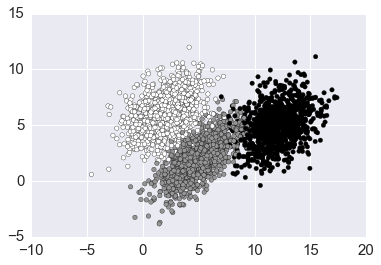

In [52]:
plt.scatter(simulated_data[:,0], simulated_data[:,1], c=simulated_data[:,-1]);

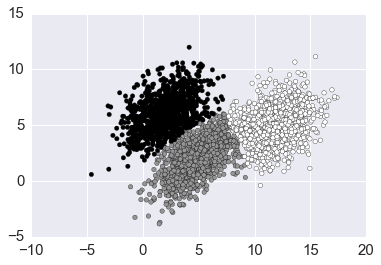

In [53]:
plt.scatter(simulated_data[:,0], simulated_data[:,1], c=y_pred_kmeans);

In [54]:
plt.scatter(data[:,0], data[:,1], c=y_pred_kmeans_plus);

NameError: name 'data' is not defined

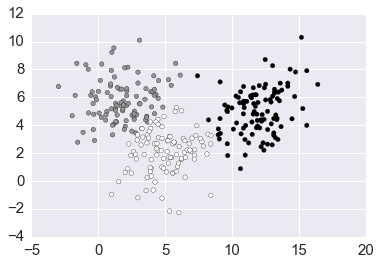

In [43]:
plt.scatter(data[:,0], data[:,1], c=y_pred_scalable_kmeans_plus);

### 5.2 Real Dataset: Red Wine Quality

In [44]:
red_wine = pd.read_csv("winequality-red.csv", sep = ";")
red_wine.quality = red_wine.quality.astype('category')
print(red_wine.shape)
red_wine.head(5)

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


In [45]:
red_wine_array = np.array(red_wine)
red_wine_data, red_wine_labels = red_wine_array[:, :-1], red_wine_array[:, -1]

In [46]:
%%time
kmeans_plus_init = kmeans_plus(red_wine_data, 10)

CPU times: user 1.53 s, sys: 4.22 ms, total: 1.53 s
Wall time: 1.53 s


In [47]:
%%time
scalable_kmeans_init = scalable_kmeans_plus(red_wine_data, 10, 2)

CPU times: user 7.51 s, sys: 25.4 ms, total: 7.54 s
Wall time: 7.56 s


In [48]:
white_wine = pd.read_csv("winequality-white.csv", sep = ";")
white_wine.quality = white_wine.quality.astype('category')
print(white_wine.shape)
white_wine.head(5)

(4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6


In [49]:
white_wine_array = np.array(white_wine)
white_wine_data, white_wine_labels = white_wine_array[:, :-1], white_wine_array[:, -1]

In [50]:
%%time
kmeans_plus_init = kmeans_plus(white_wine_data, 10)

CPU times: user 5.08 s, sys: 20.7 ms, total: 5.11 s
Wall time: 5.16 s


In [51]:
%%time
kmeans_plus_init = kmeans_plus(white_wine_data, 20)

CPU times: user 19.4 s, sys: 71.2 ms, total: 19.5 s
Wall time: 19.6 s


In [52]:
%%time
scalable_kmeans_init = scalable_kmeans_plus(white_wine_data, 10, 2)

CPU times: user 28.6 s, sys: 42.3 ms, total: 28.6 s
Wall time: 28.6 s


In [53]:
%%time
scalable_kmeans_init = scalable_kmeans_plus(white_wine_data, 20, 2)

CPU times: user 26.3 s, sys: 23.3 ms, total: 26.3 s
Wall time: 26.3 s


### 5.3 Discussion of Results